### Spectral smoothing- w40hco+

specsmooth(imagename='/Users/jane/Desktop/w40hco+/w40_hco+.fits', outfile='/Users/jane/Desktop/w40hco+/w40_hco+_smooth', axis=2, function="boxcar", width=15, overwrite=True)
    
Using width = 15 which gives channel size of 0.517 km/s

imregrid(imagename='/Users/jane/Desktop/w40hco+/w40_hco+_smooth', output='/Users/jane/Desktop/w40hco+/w40_hco+_smooth_gal', template="Galactic", overwrite=True) 

exportfits(imagename='/Users/jane/Desktop/w40hco+/w40_hco+_smooth', fitsimage='/Users/jane/Desktop/w40hco+/w40_hco+_smooth.fits', velocity=True, overwrite=True)
exportfits(imagename='/Users/jane/Desktop/w40hco+/w40_hco+_smooth_gal', fitsimage='/Users/jane/Desktop/w40hco+/w40_hco+_smooth_gal.fits', velocity=True, overwrite=True)


### Moment map- w40hco+

immoments(imagename="/Users/jane/Desktop/w40hco+/w40_hco+_smooth.fits", outfile="/Users/jane/Desktop/w40hco+/w40_hco+_smooth_mom0", moments=0, axis='spectral', chans=("range=[134chan, 154chan], restfreq=267.6, frame=LSRK")) 

imregrid(imagename='/Users/jane/Desktop/w40hco+/w40_hco+_smooth_mom0', output='/Users/jane/Desktop/w40hco+/w40_hco+_smooth_mom0_gal', template="Galactic", overwrite=True) 

exportfits(imagename='/Users/jane/Desktop/w40hco+/w40_hco+_smooth_mom0_gal', fitsimage='/Users/jane/Desktop/w40hco+/w40_hco+_smooth_mom0_gal.fits', velocity=True, overwrite=True)

### Spectral smoothing- w40hcn

specsmooth(imagename='/Users/jane/Desktop/w40hcn/w40_hcn.fits', outfile='/Users/jane/Desktop/w40hcn/w40_hcn_smooth', axis=2, function="boxcar", width=15, overwrite=True)
    
Using width = 15 which gives channel size of 0.517 km/s

imregrid(imagename='/Users/jane/Desktop/w40hcn/w40_hcn_smooth', output='/Users/jane/Desktop/w40hcn/w40_hcn_smooth_gal', template="Galactic", overwrite=True) 

exportfits(imagename='/Users/jane/Desktop/w40hcn/w40_hcn_smooth', fitsimage='/Users/jane/Desktop/w40hcn/w40_hcn_smooth.fits', velocity=True, overwrite=True)
exportfits(imagename='/Users/jane/Desktop/w40hcn/w40_hcn_smooth_gal', fitsimage='/Users/jane/Desktop/w40hcn/w40_hcn_smooth_gal.fits', velocity=True, overwrite=True)


### Moment map- w40hcn

immoments(imagename="/Users/jane/Desktop/w40hcn/w40_hcn_smooth.fits", outfile="/Users/jane/Desktop/w40hcn/w40_hcn_smooth_mom0", moments=0, axis='spectral', chans=("range=[132chan, 152chan], restfreq=265.9, frame=LSRK")) 

imregrid(imagename='/Users/jane/Desktop/w40hcn/w40_hcn_smooth_mom0', output='/Users/jane/Desktop/w40hcn/w40_hcn_smooth_mom0_gal', template="Galactic", overwrite=True) 

exportfits(imagename='/Users/jane/Desktop/w40hcn/w40_hcn_smooth_mom0_gal', fitsimage='/Users/jane/Desktop/w40hcn/w40_hcn_smooth_mom0_gal.fits', velocity=True, overwrite=True)

In [1]:
### Imports ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib.backends.backend_pdf import PdfPages
import math as m 
import os
import sys
import re

from astropy.utils import data
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import ascii
from astropy.table import Table

import warnings
warnings.filterwarnings('ignore')

# Set path to your home directory. Path will be used for all functions unless otherwise specified
path='/Users/jane/Desktop'   # path 

In [14]:
### Gaussian fit function ###
# Produces Gaussian fits for each pixel of a molecule's .fits file
# gaussFit('input file','output text file', 'molecule name convention', 'molecule')

def gaussFit(filename, outfile, molname, mol):
    
    ### Change the parameters below for each new source
    
    vel_guess = 7  # The initial guess for the centroid velocity of the gaussian fit
    dv_min = 1       # set a minimum acceptable line width
    dv_max = 9       # set a maximum acceptable line width
    snr_min = 2.5    # set a minumum acceptable SNR

    # set the range of pixels in the x direction over which to loop
    min_xpix = 29
    max_xpix = 56

    # set the range of pixels in the y direction over which to loop
    min_ypix = 15
    max_ypix = 50

    # set the velocity range over which to calculate the line integrated intensity
    min_vline = -10
    max_vline = 20

    #set the spectral resolution of the spectra in km/s
    deltaV = 0.4

    #JCMT efficiency at 230 GHz to convert TA* to Tmb
    eta = 0.6
    
    # retrieving the source data and information
    datfile = fits.open(path+'/'+filename)
    cube = SpectralCube.read(datfile)
    wcs = WCS(datfile[0].header) # vel and position info from WCS in header

    # extract the world coordinates of all the pixels using the world property, 
    # which returns the spectral axis then the two positional coordinates in reverse order 
    # (in the same order as the data indices). 
    velo, lat, long  = cube.world[:] 

    # convert the velocity units from m/s (in the fits header) to km/s
    cube2 = cube.with_spectral_unit(u.km / u.s)

    # initialize the arrays to write to an ascii table file at the end
    x, y, glat, glong, vlsr, TA, sigma, fwhm, TAdv, Tmb, Tmbdv, figs = [], [], [], [], [], [], [], [], [], [], [], []

    # sets an index for the array entries
    n = 0

    # Loop over all pixels in the x and y ranges provided, extract the spectrum at that pixel,
    # fit a gaussian to the spectrum and print and plot the results
    for i in range(min_xpix,max_xpix+1):
        for j in range(min_ypix,max_ypix+1):
            # grab a spectrum at pixel x, y 
            x.append(i)
            y.append(j)
            T = cube2[:, j, i]               # get the intensity/temperature along the spectral axis
            vel = cube2.spectral_axis        # set the velocity axis
            glat.append(lat[0,j,0])          # get the DEC/lat of pixel x/y from the world coordinates
            glong.append(long[0,0,i])        # get the RA/long of pixel x/y from the world coordinates

            # Fit the data using a Gaussian
            g_init = models.Gaussian1D(amplitude=1.0, mean=vel_guess, stddev=1.0)
            fit_g = fitting.LevMarLSQFitter()
            g = fit_g(g_init, vel, T)
            #print(g)

            gT = g.amplitude.value   # Line peak temperature of the gaussian fit  (K)
            gV = g.mean.value        # line centre velocity of the gaussian fit (km/s)
            gS = g.stddev.value      # standard deviation (sigma) width of the gaussian fit (km/s)

            noise = T.std()                      # Calculate the rms noise in the spectrum
            intnoise = deltaV * noise * u.km / u.s  # multiple the noise by the channel width we can calculate the SNR using the intergrated intensity/moment 0
            newgT = gT * u.K                     # give the Gaussian fit temp the units of K                   

            # calculate the integrated intensity of the spectrum over the line
            line = cube2.spectral_slab(min_vline*u.km / u.s, max_vline*u.km / u.s)
            max = line[:,j,i].max()       # calculate the maximum channel height in the region covered by the line
            mom0 = line.moment(order=0)
            mom_line = abs(mom0[j,i])     # extract the moment 0 value fo the desire x, y position/pixel

            # calculate the SNR 
            snr = mom_line/intnoise

            # If the SNR is > some value, the max channel is >  something * noise
            # and the FWHM is > some minimum width and < some maximum width
            # then accept the values of the gaussian fits
            # if not, then we assume that the spectrum is weak, the fit is nonsense and so
            # we set the values to 0 so we know what to ignore in the table
            if snr > snr_min and max > (snr_min*noise) and (2.355*gS) > dv_min and (2.355*gS) < dv_max :
                TA.append(gT)               # Line peak temperature of the gaussian fit  (K)
                vlsr.append(gV)             # line centre velocity of the gaussian fit (km/s)
                sigma.append(gS)            # standard deviation (sigma) width of the gaussian fit (km/s)
                fwhm.append(2.355 * gS)     # Full Width at Half Maximum of the gaussian fit  (km/s)
                Tmb.append(gT/eta)          # Calibrated Line peak temperature of the gaussian fit  (K)
            else:
                TA.append(0)           # Line peak temperature of the gaussian fit  (K)
                vlsr.append(0)         # line centre velocity of the gaussian fit (km/s)
                sigma.append(0)        # standard deviation (sigma) width of the gaussian fit (km/s)
                fwhm.append(0)         # Full Width at Half Maximum of the gaussian fit  (km/s)
                Tmb.append(0)          # Calibrated Line peak temperature of the gaussian fit  (K)
                
            # plot each of the spectra and fits    
            fig = plt.figure(figsize=(10,7), facecolor='white')
            ax = fig.add_subplot(111)  # make a single panel subplot
            #im = ax.plot(vel,T, label='Data')  # plot the data
            im = ax.step(vel, T, where='mid', label='Data')
            im = ax.plot(vel, g(vel), label='Gaussian') # plot the gaussian fit
            ax.set_xlim([min_vline,max_vline])
            ax.set_ylim([-1,8])
            ax.set_xlabel("V (km/s)", fontsize=16)
            ax.set_ylabel("T$_A^*$ (K)", fontsize=16)
            ax.text(3,6,i)
            ax.text(4,6,j)
            ax.legend()
            figs.append(fig)
            plt.close(fig) # Comment out to have plots printed in output

            n += 1    #increment the array index

    # Set the header line, the parameters, and the format of the parameters to 
    # write to an ascii table file        
    out = Table()
    out['Pix_x'] = x
    out['Pix_y'] = y
    out['GLat(deg)'] = glat
    out['GLat(deg)'].info.format = '8.7f'
    out['GLong(deg)'] = glong 
    out['GLong(deg)'].info.format = '8.7f'
    out['TA(K)'] = TA
    out['TA(K)'].info.format = '6.2f'
    out['Tmb(K)'] = Tmb
    out['Tmb(K)'].info.format = '6.2f'
    out['VLSR(km/s)'] = vlsr
    out['VLSR(km/s)'].info.format = '6.2f'
    out['sigma(km/s)'] = sigma
    out['sigma(km/s)'].info.format = '6.2f'
    out['FWHM(km/s)'] = fwhm
    out['FWHM(km/s)'].info.format = '6.2f'
    
    # Write the gaussian fits of all pixels to a text file 
    ascii.write(out, path+'/'+outfile,  overwrite=True, format='tab')
    
    # saving the list containing all the plots to a pdf file
    def save_multi_image(filename):
       pp = PdfPages(filename)
       for fig in figs:
          fig.savefig(pp, format='pdf')
       pp.close()
    
    # path where pdf file will be saved
    pdffile = path+'/'+molname+"_multi.pdf"
    save_multi_image(pdffile) # Comment out if you do not want plots saved to PDF
    print('For', mol, ':','Gaussian fit results written to', path+'/'+outfile, 'and Gaussian fit plots written to', pdffile) # Comment out if above line is

gaussFit('w40hco+/w40_hco+_smooth_gal.fits','w40_hco+_gaussfits.txt', 'w40_hco+', 'HCO+') # Gaussian fit for molecule A
gaussFit('w40hcn/w40_hcn_smooth_gal.fits','w40_hcn_gaussfits.txt', 'w40_hcn', 'HCN') # Gaussian fit for molecule B
    

For HCO+ : Gaussian fit results written to /Users/jane/Desktop/w40_hco+_gaussfits.txt and Gaussian fit plots written to /Users/jane/Desktop/w40_hco+_multi.pdf
For HCN : Gaussian fit results written to /Users/jane/Desktop/w40_hcn_gaussfits.txt and Gaussian fit plots written to /Users/jane/Desktop/w40_hcn_multi.pdf


In [6]:
### Radex column density ###
# The column density will be found using Radex for the specified molecules.

# Path to location where Radex input and output files will be saved
radexdata = '/Users/jane/Desktop/Radex/data/' 
# Path to location where Radex is run
radexpath = '/Users/jane/Desktop/Radex/bin/radex' 

# Molecule A
filename='hco+_gaussfitsTEST2.txt'    # input fits file name
outfile = 'radexHCO+_w40.inp' # file name of the radex file
X = pd.read_csv(path+'/'+filename, sep="\t", header=None)
df = pd.DataFrame(data=X)

# put pixel x, y, glat, glong, Tmb, FWHM and VLSR in lists and remove headers
xPixA = np.array(df[0].tolist())
xPixA = xPixA[1:]
yPixA = np.array(df[1].tolist())
yPixA = yPixA[1:]
glatA = np.array(df[2].tolist())
glatA = glatA[1:]
glongA = np.array(df[3].tolist())
glongA = glongA[1:]
tmbA = (df[5].tolist())
tmbA = tmbA[1:]
fwhmA = np.array(df[8].tolist())
fwhmA = fwhmA[1:]
vlsrA = np.array(df[6].tolist())
vlsrA = vlsrA[1:]


# Molecule B
filename='hcn_gaussfitsTEST2.txt'       # input fits file name
outfile = 'radexHCN_w40.inp' # file name of the radex file
X = pd.read_csv(path+'/'+filename, sep="\t", header=None)
df = pd.DataFrame(data=X)

# put pixel x, y, glat, glong, Tmb, FWHM and VLSR in lists and remove headers
xPixB = np.array(df[0].tolist())
xPixB = xPixB[1:]
yPixB = np.array(df[1].tolist())
yPixB = yPixB[1:]
glatB = np.array(df[2].tolist())
glatB = glatB[1:]
glongB = np.array(df[3].tolist())
glongB = glongB[1:]
tmbB = (df[5].tolist())
tmbB = tmbB[1:]
fwhmB = np.array(df[8].tolist())
fwhmB = fwhmB[1:]
vlsrB = np.array(df[6].tolist())
vlsrB = vlsrB[1:]

# radexcolden(xPix, yPix, glong, glat, tmb, fwhm, vlsr, freq, 'mole', 'radex inp file', 'radex out file', 'column density file')

def radexcolden(xPix, yPix, glong, glat, tmb, fwhm, vlsr, freq, mole, inputFile, outputFile, coldenFile):
    
    ### Changed from original code due to no temperature map ###


    # Run a series of Radex models to retrieve the column density
    maxiter = 100
    debug   = False

    # lists for all new data (omitting null rows)
    xPixFull, yPixFull, glongFull, glatFull, colDen, tkFull, tmbFull, vlsrFull, fwhmFull = [], [], [], [], [], [], [], [], []

    # loop through all pixels

    ran = len(xPix)

    for i in range(ran):

        #only run non-zero rows
        if tmb[i] != '0.00':

            #converting values to floats 
            b = np.asarray(tmb[i], dtype=float)
            c = np.asarray(fwhm[i], dtype=float)
            #d = np.asarray(tk[i], dtype=float)

            tkin = 25      # Tkin (K)
            nh2 = 1.0e5      # nH2 cm^-3
            tbg = 2.73       # Tbg (K)
            obs = b          # Observed line intensity (K)- Tmb
            dv = c           # FWHM line width km/s
            bw = 0.01       # Bandwidth (GHz)
            tol = 0.01       # tolerance

            extension = '.dat'

            def write_input(cdmol):
                file = open(radexdata+'/'+inputFile,'w')
                print(radexdata+'/'+inputFile)
                file.write(mole+'.dat\n') 
                file.write(radexdata+'/'+outputFile+'\n')
                print(radexdata+'/'+outputFile)
                file.write(str(freq*(1-bw))+' '+str(freq/(1-bw))+'\n')
                file.write(str(tkin)+'\n')
                file.write('1\n')
                file.write('H2\n')
                file.write(str(nh2)+'\n')
                file.write(str(tbg)+'\n')
                file.write(str(cdmol)+'\n')
                file.write(str(dv)+'\n')
                file.write('0\n')
                file.close()

            def read_radex():
                file  = open(radexdata+'/'+outputFile)
                print(radexdata+'/'+outputFile)
                lines = file.readlines()
                file.close()
                if (lines[-2].split()[-1] != '(erg/cm2/s)'):
                    print("Error: Ambiguous line selection. Reduce bandwidth?")
                    print("See radex.out for details")
                    sys.exit()
                return float(lines[-1].split()[-2])

            # Begin of main program
            oflx = obs*dv
            eps  = 1.0e-20
            iter = 0

            # Starting values of column density and fit residual
            cdmol = 1e12
            ratio = 0

            while (ratio > (1+tol)) or (ratio < (1-tol)) :
                iter += 1
                write_input(cdmol)
                os.system(radexpath+ '<' +radexdata+'/'+inputFile+ '> /dev/null' )
                print(radexpath+ '<' +radexdata+'/'+inputFile+ '> /dev/null')
                mflx  = read_radex()
                if (mflx < eps):
                    print("Error: Zero or negative line intensity")
                    print("See radex.out for details")
                    sys.exit()
                if (debug):
                    print("mflx= ",mflx)
                ratio = oflx/mflx
                cdmol = cdmol * ratio
                if (iter > maxiter):
                    print("Maximum number of iterations exceeded")
                    ratio = 1

            #fmt = "CD %7.2e cm^-2"
            cdmol = "{:.4e}".format(cdmol) # convert column density to scientific notation
            colDen.append(cdmol)
            xPixFull.append(xPix[i])
            yPixFull.append(yPix[i])
            glongFull.append(glong[i])
            glatFull.append(glat[i])
            tkFull.append(tkin)
            tmbFull.append(tmb[i])
            vlsrFull.append(vlsr[i])
            fwhmFull.append(fwhm[i])

    #writing results to table 
    outfile = coldenFile # file name of the gaussian fit results

    out = Table()
    out['Pix_x'] = xPixFull
    out['Pix_y'] = yPixFull
    out['GLat(deg)'] = glatFull
    #out['GLat(deg)'].info.format = '8.7f'
    out['GLong(deg)'] = glongFull
    out['Tk(K)'] = tkFull
    out['Tmb(K)'] = tmbFull
    #out['Tmb(K)'].info.format = '6.2f'
    out['VLSR(km/s)'] = vlsrFull
    #out['VLSR(km/s)'].info.format = '6.2f'
    out['FWHM(km/s)'] = fwhmFull
    #out['FWHM(km/s)'].info.format = '6.2f'
    #out['GLong(deg)'].info.format = '8.7f'
    out['Col. Den. (cm^-2)'] = colDen
    #out['Col. Den. (cm^-2)'].info.format = '6.2f'

    # Write the gaussian fits of all pixels to a text file 
    ascii.write(out, path+'/'+outfile,  overwrite=True, format='tab')

    print('Column density data for', mole, 'saved to', outfile)

radexcolden(xPixA, yPixA, glongA, glatA, tmbA, fwhmA, vlsrA, 267.6, 'HCO+', 'radexHCO+_w40.inp', 'radexHCO+_w40.out', 'columnDenHCO+_w40.txt')
radexcolden(xPixB, yPixB, glongB, glatB, tmbB, fwhmB, vlsrB, 265.9, 'HCN', 'radexHCN_w40.inp', 'radexHCN_w40.out', 'columnDenHCN_w40.txt')

/Users/jane/Desktop/Radex/data//radexHCO+_w40.inp
/Users/jane/Desktop/Radex/data//radexHCO+_w40.out
/Users/jane/Desktop/Radex/bin/radex</Users/jane/Desktop/Radex/data//radexHCO+_w40.inp> /dev/null
/Users/jane/Desktop/Radex/data//radexHCO+_w40.out
/Users/jane/Desktop/Radex/data//radexHCO+_w40.inp
/Users/jane/Desktop/Radex/data//radexHCO+_w40.out
/Users/jane/Desktop/Radex/bin/radex</Users/jane/Desktop/Radex/data//radexHCO+_w40.inp> /dev/null
/Users/jane/Desktop/Radex/data//radexHCO+_w40.out
/Users/jane/Desktop/Radex/data//radexHCO+_w40.inp
/Users/jane/Desktop/Radex/data//radexHCO+_w40.out
/Users/jane/Desktop/Radex/bin/radex</Users/jane/Desktop/Radex/data//radexHCO+_w40.inp> /dev/null
/Users/jane/Desktop/Radex/data//radexHCO+_w40.out
/Users/jane/Desktop/Radex/data//radexHCO+_w40.inp
/Users/jane/Desktop/Radex/data//radexHCO+_w40.out
/Users/jane/Desktop/Radex/bin/radex</Users/jane/Desktop/Radex/data//radexHCO+_w40.inp> /dev/null
/Users/jane/Desktop/Radex/data//radexHCO+_w40.out
/Users/jane/

Column density ratio data saved to /Users/jane/Desktop/coldenRatio_w40.txt


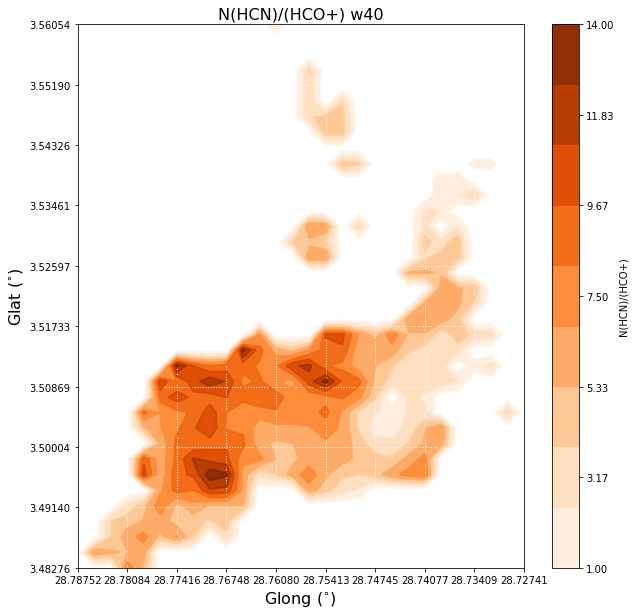

In [8]:
### Plotting column density ratio maps ###
# Can be run on it's own if column density files exists

# import HCN and HCO+ col. den. data files

# Molecule A
A = pd.read_csv(path+'/'+'columnDenHCO+_w40.txt', sep="\t", header=None)
dataA = pd.DataFrame(data=A)

# create lists for coordinates and column density (omitting the first row/header)
xPixA = np.array(dataA[0].tolist())
xPixA = xPixA[1:]
yPixA = np.array(dataA[1].tolist())
yPixA = yPixA[1:]
glatA = np.array(dataA[2].tolist())
glatA = glatA[1:]
glongA = np.array(dataA[3].tolist())
glongA = glongA[1:]
nA = np.array(dataA[8].tolist())
nA = nA[1:]
nAfloat = nA.astype(float) # float needed later on

# Molecule B
B = pd.read_csv(path+'/'+'columnDenHCN_w40.txt', sep="\t", header=None)
dataB = pd.DataFrame(data=B)

xPixB = np.array(dataB[0].tolist())
xPixB = xPixB[1:]
yPixB = np.array(dataB[1].tolist())
yPixB = yPixB[1:]
glatB = np.array(dataB[2].tolist())
glatB = glatB[1:]
glongB = np.array(dataB[3].tolist())
glongB = glongB[1:]
nB = np.array(dataB[8].tolist())
nB = nB[1:]
nBfloat = nB.astype(float) # float needed later on

### Start of trying to keep pixels in zip with glat, glong
  
# convert round glat, glong to arrays of floats and round to 4 decimals to be compared in following for loop
# don't use the "rounded" lists for final data sets. Don't have enough accuracy- only needed to compare
glatArounded = np.round(glatA.astype(float), 3)
glatBrounded = np.round(glatB.astype(float), 3)
glongArounded = np.round(glongA.astype(float), 3)
glongBrounded = np.round(glongB.astype(float), 3)

# Create tuples with full and rounded coordinates. This way we can compare the rounded ones without losing the accuracy of the full ones. 

# I didn't like how the build in zip() function was working so I made my own
def zip(list1, list2):
    list = []
    for i in range(len(list1)):
        temp = (list1[i],list2[i])
        list.append(temp)
    return(list)

glatAzip = zip(glatA, glatArounded)
glongAzip = zip(glongA, glongArounded)
glatBzip = zip(glatB, glatBrounded)
glongBzip = zip(glongB, glongBrounded)

# ensure glat,glong coordinates match xPix, yPix between molecules
for i in range(len(xPixA)):
    for j in range(len(xPixB)):
        if ((xPixA[i] == xPixB[j]) and (yPixA[i] == yPixB[j])):
            if ((glatArounded[i] != glatBrounded[j]) or (glongArounded[i] != glongBrounded[j])):
                print('Error- molecule coordinates not alligned', xPixA[i], xPixB[j])

# If no errors, use coordinates from either molecule for both (here HCO+ is used)

# Eliminating doubles from coordinate lists
# Loop searches for coordinate pair and appends if it is not already in the list

def shorten(listLong):
    x = len(listLong)
    temp = []
    for i in range(x):
        if (listLong[i] not in temp):
            temp.append(listLong[i])
            temp.sort() # reorders list from smallest to largest
    return(temp)

glatAzipShort = shorten(glatAzip)
glongAzipShort = shorten(glongAzip)
glatBzipShort = shorten(glatBzip)
glongBzipShort = shorten(glongBzip)


# <= for smaller array range, >= for larger array range
# regardless of range choice, density ratio will only populate areas both ranges cover
# here HCO+ has larger range

if (len(glatAzipShort) >= len(glatBzipShort)):
    lenglat = len(glatAzipShort)
    savedglat = list(x[0]for x in glatAzipShort) # store non-rounded glat value
else:
    lenglat = len(glatBzipShort)
    savedglat = list(x[0] for x in glatBzipShort) # store non-rounded glat value

if (len(glongAzipShort) >= len(glongBzipShort)):
    lenglong = len(glongAzipShort)
    savedglong = list(x[0] for x in glongAzipShort) # store non-rounded glong value
else:
    lenglong = len(glongBzipShort)
    savedglong = list(x[0] for x in glongBzipShort) # store non-rounded glong value
    
largeArray = np.zeros([lenglat,lenglong]) # array of desired size of zeros for chosen span of coordinates

largeCoord = []
for i in range(len(savedglat)):
    for j in range(len(savedglong)):
        largeCoord.append([savedglat[i], savedglong[j]])      

# ratio of column density will be found for pixels that contain data for both molecules

smallCoord = []
for i in range(len(glatA)):
    for j in range(len(glatB)):
        if ((glatArounded[i] == glatBrounded[j]) and (glongArounded[i] == glongBrounded[j])):
            ratio = (nBfloat[j]/nAfloat[i])
            lst = [[glatA[i], glongA[i]], ratio]
            smallCoord.append(lst)                     # coordinates of non-zero ratio
            
smallCoord = sorted(smallCoord, key=lambda tup: tup[0], reverse=True)
            
# Save N ratios to txt file
outfile = 'coldenRatio_w40.txt' # file name of the column density ratios
# Temporary lists
glatTemp, glongTemp, nTemp = [], [], []
for i in range(len(smallCoord)):
    glatTemp.append(smallCoord[i][0][0])
    glongTemp.append(smallCoord[i][0][1])
    nTemp.append(round(smallCoord[i][1],4))

out = Table()
out['GLat(deg)'] = glatTemp
out['GLong(deg)'] = glongTemp
out['(N(HCN))/(N(HCO+)) w40'] = nTemp

# Write the gaussian fits of all pixels to a text file 
ascii.write(out, path+'/'+outfile,  overwrite=True, format='tab')

print('Column density ratio data', 'saved to', path+'/'+outfile)            

# populating large array with density ratios from small array

for i in range(len(smallCoord)):
    for j in range(len(largeCoord)):
        if (smallCoord[i][0] == largeCoord[j]):
            largeArray[m.floor(j/len(savedglong))][j%len(savedglong)] = smallCoord[i][1]

# finding bounds of glat and glong coordinates and converting them to float to be used in linspace()
# works only if list values are ascending- here they are from the shorten() function applied above
glatMin = savedglat[0].astype(float)
glatMax = savedglat[-1].astype(float)
glongMin = savedglong[0].astype(float)
glongMax = savedglong[-1].astype(float)

# contour plot
u = np.linspace(glatMin, glatMax, num=len(savedglat))
v = np.linspace(glongMin, glongMax, num=len(savedglong))

from functools import reduce
levelMax = m.ceil(max(nTemp)) # round up maximum N ratio value
levelMin = m.floor(min(nTemp)) # round down minimum N ratio value
breaksFill = np.linspace(levelMin,levelMax,10) # can modify number of fill levels
breaksBar = np.linspace(levelMin,levelMax,7) # can modify number of levels in colour bar
breaksLines = np.linspace(levelMin,levelMax,10) # can modify number of contour line levels
breaksy = np.linspace(glatMin, glatMax, 10)
breaksx = np.linspace(glongMin, glongMax, 10)

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
CS1 = plt.contourf(v, u, largeArray, breaksFill, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksBar, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# contour lines
CS2 = plt.contour(v, u, largeArray, breaksLines, cmap='Oranges', linewidths=2)  

# level labels
# plt.clabel(CS2, colors='k', inline=False)

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+) w40', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

plt.grid(color='white', ls='dotted', lw=1)

plt.show()

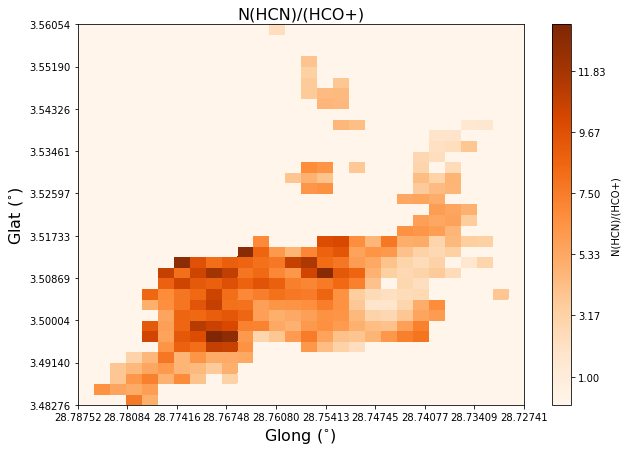

In [6]:
y = np.linspace(glatMin, glatMax, num=(len(savedglat)+1)) # y-axis
x = np.linspace(glongMin, glongMax, num=(len(savedglong)+1)) # x-axis

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
plt.pcolormesh(x,y,largeArray, cmap='Oranges')

# colour bar
cbar = plt.colorbar(ticks=breaksBar, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

plt.show()

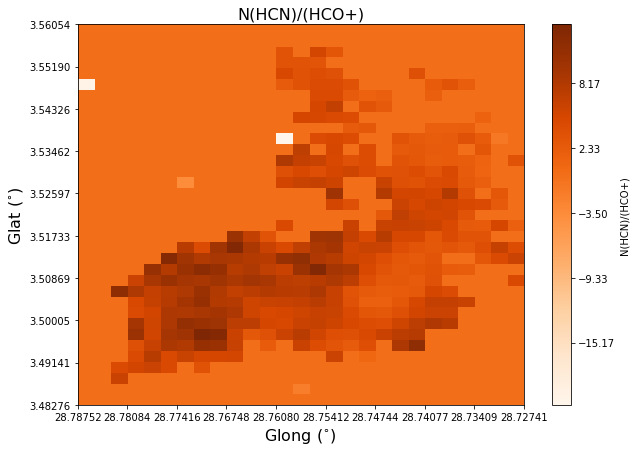

In [20]:
### Pixel plot ###

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
plt.pcolormesh(v,u,largeArray, cmap='Oranges', vmin=min(nTemp), vmax=max(nTemp))

# colour bar
cbar = plt.colorbar(ticks=breaksBar, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

plt.show()

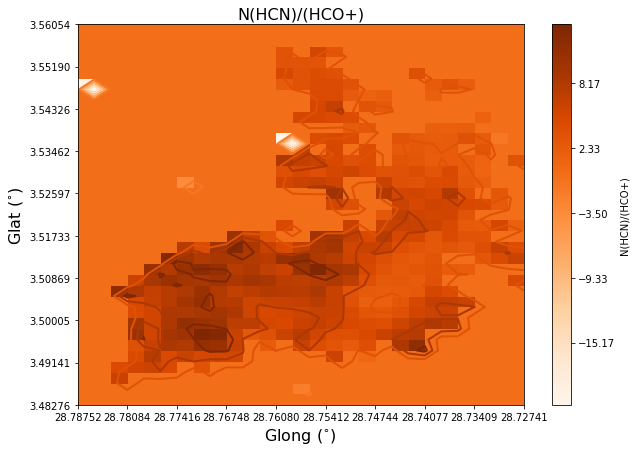

In [21]:
### Pixel plot with contour lines overlaid ###

# filled contour
fig = plt.figure(figsize=(10,7), facecolor='white')
plt.pcolormesh(v,u,largeArray, cmap='Oranges', vmin=min(nTemp), vmax=max(nTemp))

# colour bar
cbar = plt.colorbar(ticks=breaksBar, orientation='vertical')
cbar.set_label('N(HCN)/(HCO+)')

# contour lines
CS2 = plt.contour(v, u, largeArray, breaksLines, cmap='Oranges', linewidths=2) 
#plt.clabel(CS2, colors='k', inline=False)

# labels
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)
plt.title('N(HCN)/(HCO+)', size=16)

# axes
plt.yticks(breaksy)
plt.xticks(breaksx)
plt.gca().invert_xaxis()

plt.show()

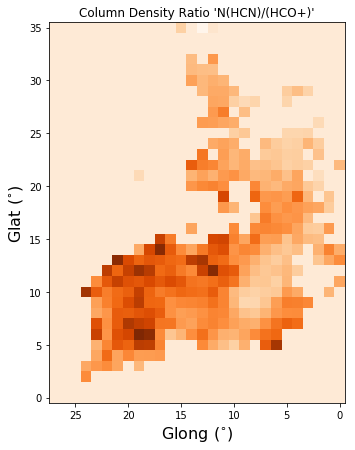

In [11]:
# creating the plot
fig = plt.figure(figsize=(10,7), facecolor='white')

#ax = plt.subplot(111)
#im = plt.subplot(111)
  
# customizing plot
plt.title("Column Density Ratio 'N(HCN)/(HCO+)'")
#CS1 = plt.plot(largeArray)
image = plt.imshow(largeArray, cmap='Oranges', interpolation='nearest')

breaksy = np.linspace(glatMax, glatMin, 10)
breaksx = np.linspace(glongMax, glongMin, 10)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Glong ($^{\circ}$)", fontsize=16)
plt.ylabel("Glat ($^{\circ}$)", fontsize=16)  

#cbar = plt.colorbar(ticks=breaksBar, orientation='vertical')
#cbar.set_label('N(HCN)/(HCO+)')
  
#plt.xticks(np.linspace(0,4,5))
    
# show plot
plt.show(image)

Floris van der Tak, R. Plume